In [643]:
from collections import OrderedDict
import os
import re
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from tqdm.notebook import tqdm
#from sklearn.linear_model import LinearRegression, Lasso
from models import LassoModel, LeastSquaresModel

from plot_utils import basic_plot, collect_results, relevant_model_names

from eval import read_run_dir, get_model_from_run, eval_batch, eval_model, generate_eval_data
from sparse_recovery.compressed_sensing import create_Fourier_basis, create_normal_basis, create_orthonormal_basis
from sparse_recovery.compressed_sensing import get_measures


In [644]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

sns.set_theme('notebook', 'darkgrid')
palette = sns.color_palette('colorblind')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [645]:
run_dir = "outputs"  # ton dossier outputs

# --- Lire toutes les runs ---
df_runs = read_run_dir(run_dir)
df_runs  # affiche les runs disponibles

,task,run_id,run_path
0,matrix_factorization,2025-09-01_15-04-29,outputs/matrix_factorization/2025-09-01_15-04-29
1,sparse_recovery,2025-09-03_12-07-27,outputs/sparse_recovery/2025-09-03_12-07-27


In [654]:

# ---------- Paramètres ----------
task_name = "sparse_recovery"
d = 20
s = 3
Phi = torch.eye(d)
N_test = 2
max_L = 50

all_tau = [0, 1]

# ---------- Stockage des losses ----------
results = {
    "Least Squares": {},
    "Lasso": {},
    "Transformer": {}
}

for tau in all_tau:
    # Jeu de test pour ce tau
    X_test, y_test, w_star, a_star = generate_eval_data(
        task_name=task_name, N=N_test, tau=tau, d=d, s=s, Phi=Phi
    )
    X_test_flat, y_test_flat = flatten_Xy_for_sklearn(X_test, y_test)
    
    ls_losses = []
    lasso_losses = []
    transformer_losses = []

    for L in range(1, max_L + 1):
        # Générer L exemples pour le contexte
        X_L, y_L, _, _ = generate_eval_data(
            task_name=task_name, N=L, tau=tau, d=d, s=s, Phi=Phi
        )
        X_L_flat, y_L_flat = flatten_Xy_for_sklearn(X_L, y_L)

        # ----- Least Squares -----
        ls = LinearRegression().fit(X_L_flat, y_L_flat)
        y_pred_ls_flat = ls.predict(X_test_flat)
        ls_losses.append(np.mean((y_test_flat - y_pred_ls_flat) ** 2))

        # ----- Lasso -----
        lasso = Lasso(alpha=0.001, max_iter=5000).fit(X_L_flat, y_L_flat)
        y_pred_lasso_flat = lasso.predict(X_test_flat)
        lasso_losses.append(np.mean((y_test_flat - y_pred_lasso_flat) ** 2))

        # ----- Transformer -----
        with torch.no_grad():
            y_pred_tr = transformer_model(X_L, y_L)  # (N_test, M, 1) par ex.
            y_pred_tr_first = to_numpy(y_pred_tr[:, 0])  # première mesure
            y_test_first = to_numpy(y_test[:, 0])       # correspondance
            mse = np.mean((y_test_first - y_pred_tr_first)**2)
            transformer_losses.append(mse)

    
    # Stocker les losses pour ce tau
    results["Least Squares"][tau] = ls_losses
    results["Lasso"][tau] = lasso_losses
    results["Transformer"][tau] = transformer_losses


/Users/macbook/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/Users/macbook/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/Users/macbook/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality 

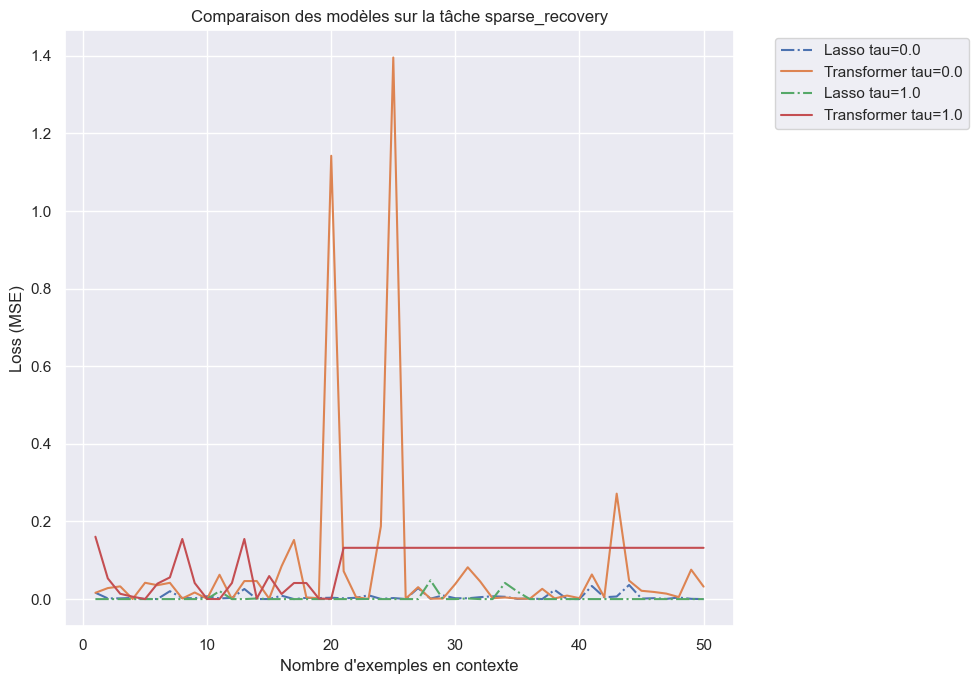

In [657]:
# ---------- Plot ----------
plt.figure(figsize=(10,7))
for tau in all_tau:
    #plt.plot(range(1, max_L+1), results["Least Squares"][tau], label=f"Least Squares tau={tau:.1f}", linestyle='--')
    plt.plot(range(1, max_L+1), results["Lasso"][tau], label=f"Lasso tau={tau:.1f}", linestyle='-.')
    plt.plot(range(1, max_L+1), results["Transformer"][tau], label=f"Transformer tau={tau:.1f}")

plt.xlabel("Nombre d'exemples en contexte")
plt.ylabel("Loss (MSE)")
plt.title(f"Comparaison des modèles sur la tâche {task_name}")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

In [627]:
def to_numpy(x):
    """Convertit torch.Tensor en numpy array si nécessaire"""
    if hasattr(x, "detach"):
        return x.detach().cpu().numpy()
    return np.array(x)

def flatten_Xy_for_sklearn(X, y):
    """Flatten X et y pour sklearn, chaque mesure devient un exemple"""
    X_np = to_numpy(X)
    y_np = to_numpy(y)
    if X_np.ndim == 3:  # (N, #mesures, d)
        N, M, d = X_np.shape
        X_flat = X_np.reshape(N*M, d)
        y_flat = y_np.reshape(N*M)
    elif X_np.ndim == 2:  # (N, d)
        X_flat = X_np
        y_flat = y_np.flatten()
    else:
        raise ValueError(f"Shape X inattendue: {X_np.shape}")
    return X_flat, y_flat

def flatten_transformer_output(y_pred, y_true):
    """Flatten le output du Transformer pour calculer le MSE"""
    y_pred_np = to_numpy(y_pred)
    y_true_np = to_numpy(y_true)
    return y_pred_np.reshape(-1), y_true_np.reshape(-1)

# ---------- Paramètres ----------
task_name = "sparse_recovery"
d = 20
s = 3
tau = 0
Phi = torch.eye(d)
N_test = 2
max_L = 50


# ---------- Charger le modèle Transformer ----------
from models import TransformerModel  # Remplace par ta classe réelle

transformer_model = TransformerModel(
    n_dims=d,          # ton d = 20
    n_positions=101,   # exactement comme à l'entraînement
    n_embd=128,
    n_layer=4,
    n_head=4
)
checkpoint_path = "outputs/sparse_recovery/2025-09-03_12-07-27/checkpoints/model_step_10000.pt"
checkpoint = torch.load(checkpoint_path)
transformer_model.load_state_dict(checkpoint['model_state_dict'])
transformer_model.eval()

# ---------- Jeu de test ----------
X_test, y_test, w_star, a_star = generate_eval_data(task_name=task_name, N=N_test, tau=tau, d=d, s=s, Phi=Phi)
X_test_flat, y_test_flat = flatten_Xy_for_sklearn(X_test, y_test)

print(X_test)
# ---------- Boucle d’évaluation ----------
ls_losses = []
lasso_losses = []
transformer_losses = []

for L in range(1, max_L + 1):
    # Générer L exemples pour le contexte
    X_L, y_L, _, _ = generate_eval_data(
        task_name=task_name, N=L, tau=tau, d=d, s=s, Phi=Phi
    )
    X_L_flat, y_L_flat = flatten_Xy_for_sklearn(X_L, y_L)

    # ----- Least Squares -----
    ls = LinearRegression().fit(X_L_flat, y_L_flat)
    y_pred_ls_flat = ls.predict(X_test_flat)
    ls_losses.append(np.mean((y_test_flat - y_pred_ls_flat) ** 2))

    # ----- Lasso -----
    lasso = Lasso(alpha=0.01, max_iter=5000).fit(X_L_flat, y_L_flat)
    y_pred_lasso_flat = lasso.predict(X_test_flat)
    lasso_losses.append(np.mean((y_test_flat - y_pred_lasso_flat) ** 2))

    # ----- Transformer -----
    with torch.no_grad():
        # Prédire la première mesure uniquement
        y_pred_tr_flat = to_numpy(y_pred_tr)[:, 0]      # (N_test,)
        y_test_flat_tr = to_numpy(y_test[:, 0])         # (N_test,)
        mse = np.mean((y_test_flat_tr - y_pred_tr_flat)**2)
        transformer_losses.append(mse)

tensor([[[-0.0447,  0.2077,  0.1681,  0.0634,  0.1816, -0.1033, -0.3703,
          -0.3040,  0.1965, -0.0358, -0.0428,  0.1932, -0.4177, -0.0061,
          -0.1281,  0.1963,  0.1121,  0.2211,  0.2073, -0.1446],
         [ 0.0113,  0.0671, -0.2842,  0.0572,  0.2002, -0.7427, -0.0798,
          -0.3476, -0.1338, -0.2039, -0.0369, -0.0313,  0.0065,  0.3862,
          -0.1259,  0.1273,  0.2037, -0.2290, -0.0962, -0.0774]],

        [[-0.0447,  0.2077,  0.1681,  0.0634,  0.1816, -0.1033, -0.3703,
          -0.3040,  0.1965, -0.0358, -0.0428,  0.1932, -0.4177, -0.0061,
          -0.1281,  0.1963,  0.1121,  0.2211,  0.2073, -0.1446],
         [ 0.0113,  0.0671, -0.2842,  0.0572,  0.2002, -0.7427, -0.0798,
          -0.3476, -0.1338, -0.2039, -0.0369, -0.0313,  0.0065,  0.3862,
          -0.1259,  0.1273,  0.2037, -0.2290, -0.0962, -0.0774]]])


/Users/macbook/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


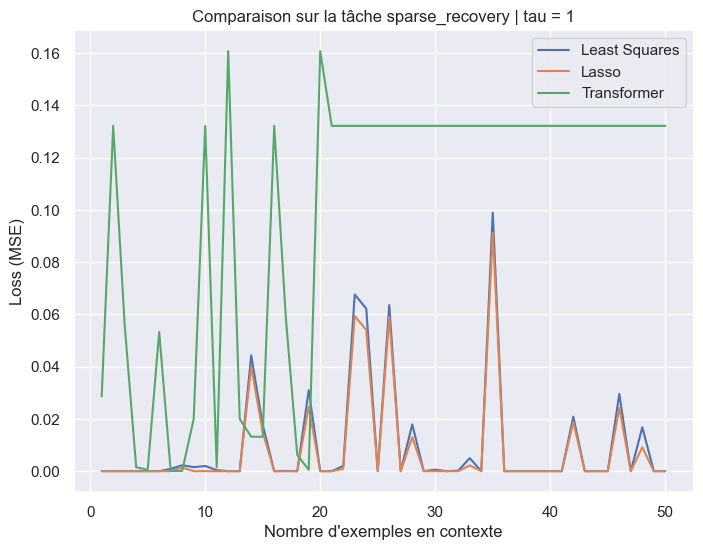

In [652]:
plt.figure(figsize=(8,6))
plt.plot(range(1, max_L+1), ls_losses, label="Least Squares")
plt.plot(range(1, max_L+1), lasso_losses, label="Lasso")
plt.plot(range(1, max_L+1), transformer_losses, label="Transformer")
plt.xlabel("Nombre d'exemples en contexte")
plt.ylabel("Loss (MSE)")
plt.title(f"Comparaison sur la tâche {task_name} | tau = {tau}")
plt.legend()
plt.grid(True)
plt.show()

In [416]:
# Paramètres pour la génération des données
d = conf.model.n_dims
N = 20
s = 5
n1 = 20
n2 = 20
rank = 3
seed= 42
Phi = torch.eye(d)
problem = 'matrix-completion'

#problem = 'matrix-sensing'
#Phi = create_Fourier_basis(d) # Fourier basis
#Phi = create_orthonormal_basis(d, scaler=None, seed=seed) # Q of QR decomposition
#Phi = create_normal_basis(n, scaler=None, seed=seed, normalized=False) # Random Normal

taus = [0.0, 0.5, 1.0]
task_results = {}

for task_name in task_list:
    # Prendre le premier run de chaque tâche
    run_row = df_runs[df_runs['task'] == task_name].iloc[0]
    run_id = run_row['run_id']
    run_path = run_row['run_path']

    print(f"=== Evaluating {task_name} / {run_id} ===")
    
    # Charger le modèle
    model, conf = get_model_from_run(run_path)
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = model.to(device).eval()

    for tau in taus:
        # Générer un batch
        if task_name == "sparse_recovery":
            X, y, w_star, a_star = generate_eval_data(
                task_name=task_name,
                N=N,
                tau=tau,
                d=d,
                s=s,
                Phi=Phi
            )
        elif task_name == "matrix_factorization":
            X, y, U_star, V_star = generate_eval_data(
                task_name=task_name,
                N=N,
                tau=tau,
                n1=n1,
                n2=n2,
                rank=rank,
                problem=problem
            )

        # Calculer la métrique
        metrics = eval_batch(model, X, y)

        # Stocker les résultats
        all_results.append({
            "task": task_name,
            "run_id": run_id,
            "tau": tau,
            "metric": metrics.mean().item(),
            "n_points":X.shape[1] - 1,
            "model_name": conf.model.name if hasattr(conf.model, "name") else "transformer"
        })

=== Evaluating matrix_factorization / 2025-09-01_15-04-29 ===
Model loaded from outputs/matrix_factorization/2025-09-01_15-04-29/checkpoints/model_step_1000.pt
[Matrix Factorization Sampler] A*: (20, 20), U*: (20, 20), V*: (20, 20)
[Matrix Factorization Sampler] problem=matrix-completion, N=20, tau=0.0
[Matrix Factorization Sampler] A*: (20, 20), U*: (20, 20), V*: (20, 20)
[Matrix Factorization Sampler] problem=matrix-completion, N=20, tau=0.5
[Matrix Factorization Sampler] A*: (20, 20), U*: (20, 20), V*: (20, 20)
[Matrix Factorization Sampler] problem=matrix-completion, N=20, tau=1.0
=== Evaluating sparse_recovery / 2025-09-01_14-13-51 ===
Model loaded from outputs/sparse_recovery/2025-09-01_14-13-51/checkpoints/model_step_1000.pt
[Compressed Sensing Sampler] Using Phi of shape (20, 20) (type: Tensor)
[Compressed Sensing Sampler] Using Phi of shape (20, 20) (type: Tensor)
[Compressed Sensing Sampler] Using Phi of shape (20, 20) (type: Tensor)


In [631]:
# --- Convertir en DataFrame ---
results_df = pd.DataFrame(all_results)
display(results_df)

""


In [632]:
def evaluate_transformer_grid(model, task_name, tau_values, n_points_values, sampler_kwargs):
    """
    Évalue le Transformer sur toutes les combinaisons de tau et n_points.
    Renvoie un DataFrame prêt pour la heatmap.
    """
    all_results = []

    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = model.to(device).eval()

    for tau in tau_values:
        for N in n_points_values:
            # Générer les données
            X, y, w_star, a_star = generate_eval_data(
                task_name=task_name,
                N=N,
                tau=tau,
                **sampler_kwargs
            )

            # Evaluer le Transformer
            error = eval_batch(model, X, y).mean().item()

            all_results.append({
                "task": task_name,
                "tau": tau,
                "n_points": N,
                "metric": error
            })

    return pd.DataFrame(all_results)

def plot_transformer_performance(results_df, task_name):
    """
    Affiche la heatmap des performances du Transformer.
    """
    df = results_df[results_df['task'] == task_name]

    if df.empty:
        print(f"Aucune donnée pour la tâche {task_name}")
        return

    plt.figure(figsize=(8,6))

    pivot_table = df.pivot_table(
        index="tau",
        columns="n_points",
        values="metric",
        aggfunc=np.mean
    )

    sns.heatmap(
        pivot_table,
        cmap="mako_r",
        annot=True, fmt=".4f",
        cbar_kws={"label": "Erreur (MSE)"}
    )
    plt.xlabel("Nombre d'exemples en contexte (n_points)")
    plt.ylabel("Tau")
    plt.title(f"Performance du Transformer - {task_name}")
    plt.show()


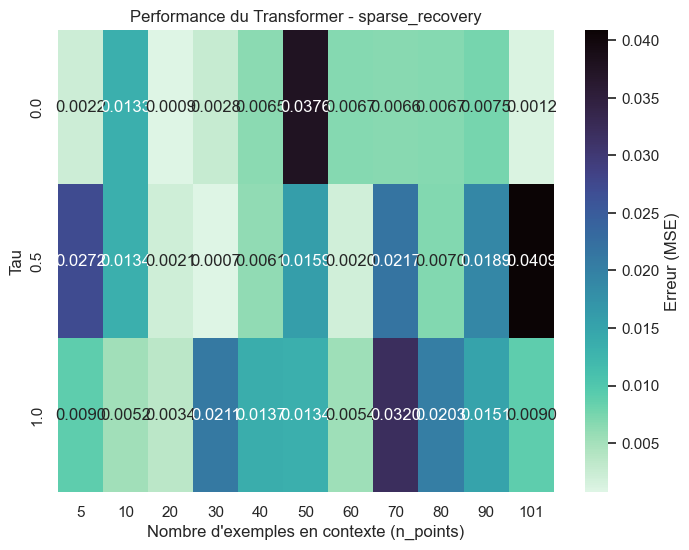

In [633]:
tau_values = [0.0, 0.5, 1.0]
n_points_values = [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 101]

sampler_kwargs = {
    "d": 20,
    "s": 3,
    "Phi": "normal"
}

results_df = evaluate_transformer_grid(model, "sparse_recovery", tau_values, n_points_values, sampler_kwargs)
plot_transformer_performance(results_df, "sparse_recovery")


In [634]:
def plot_transformer_performance_line(results_df, task_name):
    """
    Affiche un line plot des performances du Transformer.
    Chaque ligne correspond à une valeur de tau.
    """
    df = results_df[results_df['task'] == task_name]

    if df.empty:
        print(f"Aucune donnée pour la tâche {task_name}")
        return

    plt.figure(figsize=(8,5))

    # Récupérer les tau uniques pour tracer une ligne par tau
    tau_values = sorted(df['tau'].unique())

    for tau in tau_values:
        df_tau = df[df['tau'] == tau]
        # On trie par nombre d'exemples pour un tracé correct
        df_tau = df_tau.sort_values('n_points')
        plt.plot(
            df_tau['n_points'],
            df_tau['metric'],
            #marker='o',
            label=f"tau = {tau}"
        )
        

    plt.xlabel("Nombre d'exemples en contexte (n_points)")
    plt.ylabel("Erreur (MSE)")
    plt.title(f"Performance du Transformer - {task_name}")
    plt.legend()
    plt.grid(True)
    plt.show()


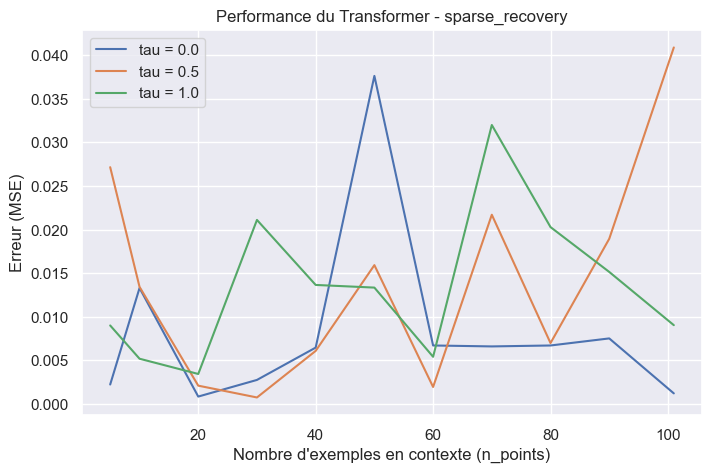

In [635]:
plot_transformer_performance_line(results_df, "sparse_recovery")

In [339]:
def evaluate_transformer_grid_mf(model, task_name, tau_values, n_points_values, sampler_kwargs):
    """
    Évalue un Transformer sur matrix factorization pour différentes valeurs de tau et n_points.
    
    Parameters:
    -----------
    model : nn.Module
        Transformer entraîné pour matrix factorization
    task_name : str
        Nom de la tâche ("matrix_factorization")
    tau_values : list[float]
        Liste des valeurs de tau à tester
    n_points_values : list[int]
        Liste des nombres d'exemples contextuels à tester
    sampler_kwargs : dict
        Arguments pour le sampler : n1, n2, rank, problem
    
    Returns:
    --------
    pd.DataFrame : DataFrame avec colonnes ["task", "tau", "n_points", "metric"]
    """
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = model.to(device).eval()
    
    all_results = []
    
    for tau in tau_values:
        for N in n_points_values:
            # Générer un batch d'évaluation
            X, y, U_star, V_star = generate_eval_data(
                task_name=task_name,
                N=N,
                tau=tau,
                **sampler_kwargs
            )
            
            # Transformer
            with torch.no_grad():
                # X doit être (batch, L, n_dims)
                if len(X.shape) == 2:  # ajouter une dimension batch
                    X = X.unsqueeze(0)
                    y = y.unsqueeze(0)
                error = eval_batch(model, X, y).mean().item()
            
            all_results.append({
                "task": task_name,
                "tau": tau,
                "n_points": N,
                "metric": error
            })
    
    return pd.DataFrame(all_results)


In [636]:
def plot_transformer_performance_mf(results_df, task_name):
    """
    Plot performance Transformer matrix factorization.
    Ordonnées: tau
    Abscisses: n_points
    Valeurs: erreur (metric)
    """
    plt.figure(figsize=(8,6))
    
    pivot_table = results_df.pivot_table(
        index="tau", columns="n_points", values="metric", aggfunc=np.mean
    )
    
    sns.heatmap(
        pivot_table,
        cmap="mako_r", annot=True, fmt=".3f",
        cbar_kws={"label": "Erreur (MSE)"}
    )
    plt.xlabel("Nombre d'exemples contextuels (n_points)")
    plt.ylabel("Tau")
    plt.title(f"{task_name} - Performance Transformer")
    plt.show()


In [295]:
# --- Plot ---
def plot_transformer_performance(results_df, task_name):
    """
    results_df doit contenir les colonnes :
      - 'n_points' (nombre d'exemples en contexte)
      - 'tau'
      - 'error' (MSE ou loss)
    """
    plt.figure(figsize=(8,6))
    
    # Pivot pour avoir une matrice (tau vs n_points)
    pivot_table = results_df.pivot_table(
        index="tau", columns="n_points", values="metric", aggfunc=np.mean
    )

    # Heatmap
    sns.heatmap(
        pivot_table,
        cmap="mako_r", annot=True, fmt=".3f",
        cbar_kws={"label": "Erreur (MSE)"}
    )

    plt.title(f"Performance du Transformer - {task_name}")
    plt.xlabel("Nombre d'exemples en contexte (N)")
    plt.ylabel("Tau")
    plt.tight_layout()
    plt.show()

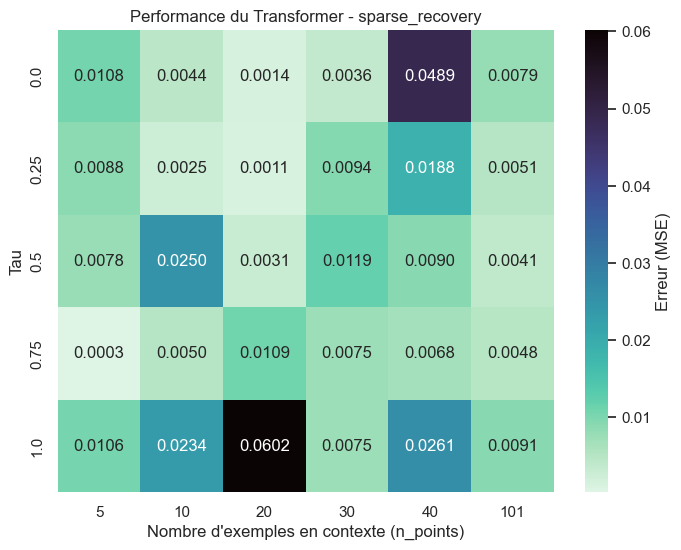

In [344]:
plot_transformer_performance(results_df, "sparse_recovery")

In [345]:
plot_transformer_performance(results_df, "matrix_factorization")

Aucune donnée pour la tâche matrix_factorization


In [346]:

def eval_batch(model, X, y):
    """Évalue un modèle pytorch sur un batch."""
    device = "cuda" if torch.cuda.is_available() else "cpu"
    pred = model(X.to(device), y.to(device)).detach()
    loss = ((pred.cpu() - y) ** 2).mean(dim=1)
    return loss

def generate_eval_data(task_name, **kwargs):
    """Génère les données d'évaluation selon la tâche."""
    sampler = get_data_sampler(task_name, **kwargs)
    return sampler.sample()

def get_baselines(task_name):
    """Retourne les baselines à évaluer."""
    if task_name == "sparse_recovery":
        return {"Lasso": LassoModel(alpha=0.01)}
    elif task_name == "matrix_factorization":
        return {"SVD": SVDModel(rank=kwargs.get("rank", 5))}
    return {}

def eval_model(model, task_name, N, taus, **kwargs):
    """Évalue le Transformer et les baselines sur plusieurs tau."""
    all_metrics = {tau: {} for tau in taus}
    baselines = get_baselines(task_name)

    for tau in taus:
        # Génération du batch
        X, y, w_star, a_star = generate_eval_data(task_name, N=N, tau=tau, **kwargs)

        # Transformer
        all_metrics[tau]["Transformer"] = eval_batch(model, X, y).mean().item()

        # Baselines
        for name, baseline in baselines.items():
            baseline_pred = baseline.predict(X)  # méthode propre à chaque baseline
            loss = ((baseline_pred - y) ** 2).mean().item()
            all_metrics[tau][name] = loss

    return all_metrics

def plot_results(metrics, task_name):
    """Plot comparatif pour chaque tau."""
    taus = list(metrics.keys())
    plt.figure(figsize=(7,5))
    for model_name in list(metrics[taus[0]].keys()):
        values = [metrics[tau][model_name] for tau in taus]
        plt.plot(taus, values, marker='o', label=model_name)
    plt.xlabel("Tau")
    plt.ylabel("MSE")
    plt.title(f"{task_name} - Transformer vs Baselines")
    plt.legend()
    plt.show()

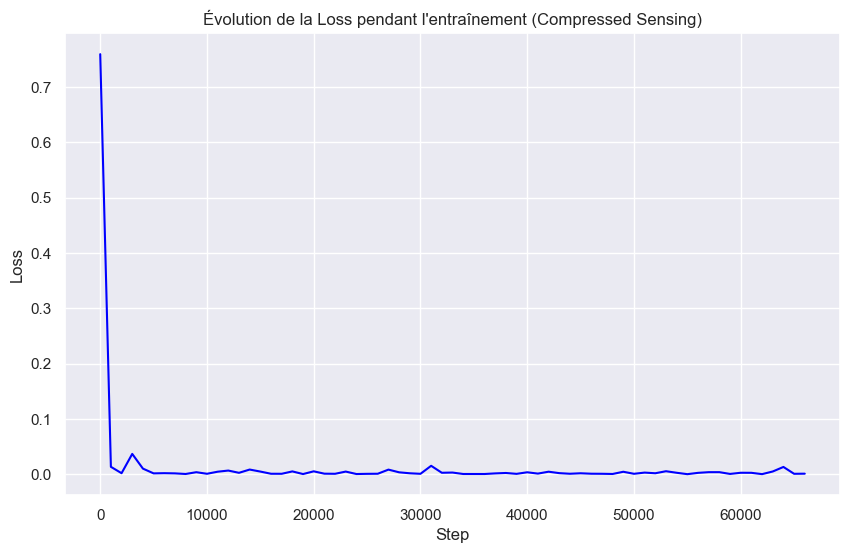

In [661]:
import matplotlib.pyplot as plt
import re
import numpy as np

# --- Lire le log depuis un fichier ou copier-coller le texte dans une variable ---
log_text = """Step 1/200000 | Loss: 0.759311 | Weights mean: -0.004579, std: 0.127498
Step 1000/200000 | Loss: 0.013451 | Weights mean: -0.004551, std: 0.127582
Step 2000/200000 | Loss: 0.001897 | Weights mean: -0.004607, std: 0.127615
Step 3000/200000 | Loss: 0.036763 | Weights mean: -0.004617, std: 0.127761
Step 4000/200000 | Loss: 0.010201 | Weights mean: -0.004641, std: 0.127951
Step 5000/200000 | Loss: 0.001595 | Weights mean: -0.004685, std: 0.127892
Step 6000/200000 | Loss: 0.001947 | Weights mean: -0.004706, std: 0.127849
Step 7000/200000 | Loss: 0.001591 | Weights mean: -0.004717, std: 0.127780
Step 8000/200000 | Loss: 0.000484 | Weights mean: -0.004745, std: 0.127777
Step 9000/200000 | Loss: 0.003708 | Weights mean: -0.004779, std: 0.127844
Step 10000/200000 | Loss: 0.000861 | Weights mean: -0.004800, std: 0.127875
Step 11000/200000 | Loss: 0.004598 | Weights mean: -0.004829, std: 0.127947
Step 12000/200000 | Loss: 0.006677 | Weights mean: -0.004854, std: 0.127992
Step 13000/200000 | Loss: 0.002582 | Weights mean: -0.004865, std: 0.128069
Step 14000/200000 | Loss: 0.008502 | Weights mean: -0.004891, std: 0.128149
Step 15000/200000 | Loss: 0.004859 | Weights mean: -0.004901, std: 0.128200
Step 16000/200000 | Loss: 0.000890 | Weights mean: -0.004919, std: 0.128285
Step 17000/200000 | Loss: 0.000848 | Weights mean: -0.004922, std: 0.128385
Step 18000/200000 | Loss: 0.005136 | Weights mean: -0.004935, std: 0.128445
Step 19000/200000 | Loss: 0.000370 | Weights mean: -0.004938, std: 0.128539
Step 20000/200000 | Loss: 0.005276 | Weights mean: -0.004937, std: 0.128623
Step 21000/200000 | Loss: 0.001033 | Weights mean: -0.004940, std: 0.128650
Step 22000/200000 | Loss: 0.000834 | Weights mean: -0.004936, std: 0.128734
Step 23000/200000 | Loss: 0.004837 | Weights mean: -0.004937, std: 0.128848
Step 24000/200000 | Loss: 0.000415 | Weights mean: -0.004937, std: 0.128998
Step 25000/200000 | Loss: 0.000763 | Weights mean: -0.004935, std: 0.129053
Step 26000/200000 | Loss: 0.000913 | Weights mean: -0.004933, std: 0.129155
Step 27000/200000 | Loss: 0.008387 | Weights mean: -0.004939, std: 0.129230
Step 28000/200000 | Loss: 0.003501 | Weights mean: -0.004931, std: 0.129316
Step 29000/200000 | Loss: 0.001756 | Weights mean: -0.004933, std: 0.129413
Step 30000/200000 | Loss: 0.000802 | Weights mean: -0.004930, std: 0.129493
Step 31000/200000 | Loss: 0.015265 | Weights mean: -0.004934, std: 0.129594
Step 32000/200000 | Loss: 0.002680 | Weights mean: -0.004937, std: 0.129670
Step 33000/200000 | Loss: 0.003072 | Weights mean: -0.004930, std: 0.129766
Step 34000/200000 | Loss: 0.000482 | Weights mean: -0.004933, std: 0.129857
Step 35000/200000 | Loss: 0.000460 | Weights mean: -0.004937, std: 0.129972
Step 36000/200000 | Loss: 0.000445 | Weights mean: -0.004936, std: 0.130054
Step 37000/200000 | Loss: 0.001553 | Weights mean: -0.004936, std: 0.130207
Step 38000/200000 | Loss: 0.002299 | Weights mean: -0.004930, std: 0.130326
Step 39000/200000 | Loss: 0.000722 | Weights mean: -0.004931, std: 0.130397
Step 40000/200000 | Loss: 0.003570 | Weights mean: -0.004928, std: 0.130504
Step 41000/200000 | Loss: 0.001182 | Weights mean: -0.004933, std: 0.130604
Step 42000/200000 | Loss: 0.004617 | Weights mean: -0.004923, std: 0.130746
Step 43000/200000 | Loss: 0.002013 | Weights mean: -0.004934, std: 0.130797
Step 44000/200000 | Loss: 0.000907 | Weights mean: -0.004938, std: 0.130811
Step 45000/200000 | Loss: 0.001779 | Weights mean: -0.004936, std: 0.130944
Step 46000/200000 | Loss: 0.000966 | Weights mean: -0.004940, std: 0.130964
Step 47000/200000 | Loss: 0.000855 | Weights mean: -0.004938, std: 0.131095
Step 48000/200000 | Loss: 0.000499 | Weights mean: -0.004936, std: 0.131225
Step 49000/200000 | Loss: 0.004499 | Weights mean: -0.004934, std: 0.131317
Step 50000/200000 | Loss: 0.000833 | Weights mean: -0.004939, std: 0.131420
Step 51000/200000 | Loss: 0.002988 | Weights mean: -0.004934, std: 0.131484
Step 52000/200000 | Loss: 0.001807 | Weights mean: -0.004941, std: 0.131581
Step 53000/200000 | Loss: 0.005476 | Weights mean: -0.004933, std: 0.131715
Step 54000/200000 | Loss: 0.002670 | Weights mean: -0.004929, std: 0.131836
Step 55000/200000 | Loss: 0.000149 | Weights mean: -0.004935, std: 0.131877
Step 56000/200000 | Loss: 0.002529 | Weights mean: -0.004933, std: 0.131951
Step 57000/200000 | Loss: 0.003754 | Weights mean: -0.004934, std: 0.132035
Step 58000/200000 | Loss: 0.003777 | Weights mean: -0.004934, std: 0.132154
Step 59000/200000 | Loss: 0.000584 | Weights mean: -0.004928, std: 0.132316
Step 60000/200000 | Loss: 0.002698 | Weights mean: -0.004921, std: 0.132323
Step 61000/200000 | Loss: 0.002603 | Weights mean: -0.004923, std: 0.132437
Step 62000/200000 | Loss: 0.000213 | Weights mean: -0.004921, std: 0.132565
Step 63000/200000 | Loss: 0.004996 | Weights mean: -0.004917, std: 0.132634
Step 64000/200000 | Loss: 0.013201 | Weights mean: -0.004915, std: 0.132733
Step 65000/200000 | Loss: 0.000819 | Weights mean: -0.004920, std: 0.132892
Step 66000/200000 | Loss: 0.001029 | Weights mean: -0.004917, std: 0.133016"""

# --- Extraire les steps et losses ---
steps = [int(m.group(1)) for m in re.finditer(r"Step (\d+)/", log_text)]
losses = [float(m.group(1)) for m in re.finditer(r"Loss: ([0-9.]+)", log_text)]

# --- Convertir en numpy ---
steps = np.array(steps)
losses = np.array(losses)

# --- Tracé ---
plt.figure(figsize=(10,6))
plt.plot(steps, losses, marker='', linestyle='-', color='blue', label="Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Évolution de la Loss pendant l'entraînement (Compressed Sensing)")
plt.show()

